In [1]:
import numpy as np
import os, glob, sys, toml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import imageio
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

sys.path.append('/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src')
import NSGA2

# Load data

In [2]:
# load basin info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# load cluster info
infile = "../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt"
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(
    columns={"Camels_IDs": "hru_id", "flood_cluster": "clusters"}
)
df_cluster2 = pd.DataFrame()

for id in df_info["hru_id"].values:
    dfi = df_cluster.loc[df_cluster["hru_id"] == id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.sel_index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster["clusters"] = df_cluster["clusters"] - 1  # starting from 0

if np.any(df_info["hru_id"].values - df_cluster['hru_id'].values != 0):
    print("Mistmatch between basins and clusters")
else:
    print("basins and clusters match")

basins and clusters match


/glade/derecho/scratch/guoqiang/tmp/ipykernel_66293/570182157.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_cluster2.sel_index = np.arange(len(df_cluster2))


Number 45
[467 494 495 496 497 498 508 509 510 511 512 513 514 515 516 517 518 521
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 554 609 620 621 622 624 625 626]


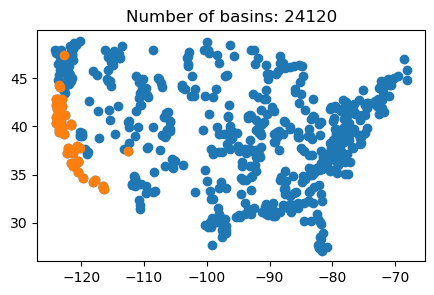

In [4]:
# select a cluster
sel_cluster = 2
sel_index = df_cluster["clusters"].values == sel_cluster
print('Number', np.sum(sel_index))

sel_index = np.where(sel_index)[0]
print(sel_index)

plt.figure(figsize=[5, 3])
plt.scatter(df_info["lon_cen"], df_info["lat_cen"])
plt.scatter(df_info["lon_cen"].values[sel_index], df_info["lat_cen"].values[sel_index])
plt.title(f"Number of basins: {np.sum(sel_index)}")
plt.show()


# Load metrics

In [5]:
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/'
basinnum = 627
iternum = 9
trialnum = 400 + (iternum-1)*40

# 2: GPR, RF; 
emulator_metrics = np.nan * np.zeros([basinnum, iternum, 2]) 

model_metrics = np.nan * np.zeros([basinnum, trialnum, 3]) # metric-1, metric-2, iter 


for i in range(basinnum):

    if not i in sel_index:
        continue

    flag = 0
    for j in range(iternum):
        # emulator metrics
        infiles_ij = [f'{inpath}/level1_{i}_MOASMOcalib/param_sets/GPR_for_iter{j}_CV_kge.csv', 
                      f'{inpath}/level1_{i}_MOASMOcalib/param_sets/RF_for_iter{j}_CV_kge.csv']
        for p in range(2):
            infile_ijp = infiles_ij[p]
            df = pd.read_csv(infile_ijp)
            emulator_metrics[i, j, p] = df['kge_mean'].values[-1]
        
        # ctsm model metrics
        filemet = f'{inpath}/level1_{i}_MOASMOcalib/ctsm_outputs/iter{j}_all_metric.csv'
        dfi = pd.read_csv(filemet)
        dfi['iter'] = j

        model_metrics[i, flag:flag+len(dfi), :] = dfi.values

        flag = flag+len(dfi)
        

# Pareto rank analysis
1. I have results from all iterations
2. I calculate the rank of all simulations for all iterations
3. For each iteration, I calculate the mean rank from its simulations and minimum rank from its simulations
4. I plot the mean rank and minimum rank with iterations

For the minimum rank, if it decreases with iterations, this is means calibration finds better solutions. For mean rank, it is less obvious compared to minimum rank because it shows the average of all simulations within an iteration.

In [6]:
if os.path.isfile(f'MOASMO_rank_iter0-8_cluster{sel_cluster}.npz'):
    dtmp = np.load('MOASMO_rank_iter0-8.npz')
    allranks = dtmp['allranks']

else:

    allranks = np.nan * np.zeros([basinnum, trialnum])
    for tarbasin in range(0, basinnum):

        if tarbasin in sel_index:
        
            met = model_metrics[tarbasin, :, 0:2]
            rank, dom = NSGA2.fast_non_dominated_sort(met)
            allranks[tarbasin,:] = rank

    np.savez_compressed(f'MOASMO_rank_iter0-8_cluster{sel_cluster}.npz',allranks=allranks)

FileNotFoundError: [Errno 2] No such file or directory: 'MOASMO_rank_iter0-8.npz'

In [ ]:
# mean / min Pareto rank

iterranks = np.nan * np.zeros([basinnum, iternum, 2])
defaranks = np.nan * np.zeros(basinnum)

for tarbasin in range(0, basinnum):
    if tarbasin in sel_index:
        iters = model_metrics[tarbasin, :, 2]
        rank = allranks[tarbasin,:]
        defaranks[tarbasin] = rank[0]
        for i in range(iternum):
            ranki = rank[iters==i]
            iterranks[tarbasin,i,0] = np.mean(ranki)
            iterranks[tarbasin,i,1] = np.min(ranki)

# mean ranks
iternames = ['defa'] + list(np.arange(iternum))

fig = plt.figure(figsize=[10, 4])

fig.add_subplot(1,2,1)
d1 = np.nanmean(iterranks[:,:,0],axis=0)
d2 = np.nanmean(defaranks)
plt.plot(iternames, np.hstack([d2, d1]), '-o')
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('Pareto rank')
plt.title('(a) Mean rank of simulations from an iteration')


fig.add_subplot(1,2,2)
d1 = np.nanmean(iterranks[:,:,1],axis=0)
d2 = np.nanmean(defaranks)
plt.plot(iternames, np.hstack([d2, d1]), '-o')
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('Pareto rank')
plt.title('(b) Minimum rank of simulations from an iteration')

plt.tight_layout()
# plt.savefig(f'allbasin_mean_min_rank_cluster{sel_cluster}.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# iteration-0 has Pareto rank 0 (i.e., best parameters)
iter0_best_ratio = np.nan * np.zeros(basinnum)

iters = model_metrics[sel_index[0],:,2]
index = iters == 0
for i in range(basinnum):
    if i in sel_index:
        ranki = allranks[i]
        iter0_best_ratio[i] = np.sum(ranki < np.min(ranki[index])  ) / np.sum(ranki>=0)

fig = plt.figure(figsize=[5, 4])
plt.hist(iter0_best_ratio, facecolor='skyblue', edgecolor='k', alpha=0.7)
plt.xlabel('Ratio')
plt.ylabel('Basin number')
plt.title('Ratio of samples that are better than optimal parameters in iter-0')
# plt.savefig(f'iter0_pareto_front_ratio_cluster{sel_cluster}.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Create a PDF saving all basins

In [ ]:
cmap = cm.cool
norm = Normalize(vmin=0, vmax=iternum-1)  # Set the normalization from 0 to 15

values = np.linspace(0, iternum-1, iternum)
colors = cmap(norm(values))
iternames = ['defa'] + list(np.arange(iternum))

file_plot = f'paretorank_camels_i0-{iternum-1}_cluster{sel_cluster}.pdf'
with PdfPages(file_plot) as pdf:

    for b in range(basinnum):

        if not b in sel_index:
            continue
        
        
        fig = plt.figure(figsize=[10, 7])

        # 1. plot all trials
        fig.add_subplot(2,2,1)

        met1 = model_metrics[b, :, 0]
        met2 = model_metrics[b, :, 1]
        iters = model_metrics[b, :, 2]
        plt.scatter(met1, met2, 5, iters, cmap=cmap, norm=norm)
        plt.colorbar(label='iteration')
        plt.xlabel('daily mean abs error (m3/s)')
        plt.ylabel('max monthly abs error (m3/s)')
        plt.title('(a) All interations')

        # plot the default parameter
        plt.scatter(met1[0], met2[0], 30, marker='D', color='k')

         # 2. plot emulator performance
        fig.add_subplot(2,2,2)

        met1 = emulator_metrics[b, :, 0]
        met2 = emulator_metrics[b, :, 1]
        plt.plot(met1, '-o', label='GPR')
        plt.plot(met2, '-o', label='RF')
        # plt.ylim(0, 1)
        plt.xlabel('iteration')
        plt.ylabel("Emulator CV KGE'")
        plt.title('(b) Emulator performance')
        plt.legend()
        
        # 3. plot the performance change (best performance for each iteration)
        fig.add_subplot(2,2,3)
        
        d1 = iterranks[b,:,1]
        d2 = defaranks[b]
        plt.plot(iternames, np.hstack([d2, d1]), '-o')
            
        plt.xlabel('iteration')
        plt.ylabel('Pareto rank')
        plt.title('(c) Minimum rank for each iteration')

        # 4. insert text
        fig.add_subplot(2,2,4)
        plt.axis('off')
        plt.text(0.1, 0.9, f'basinid: {b}')
        s = df_info.iloc[b]['hru_id']
        plt.text(0.1, 0.8, f'hru_id: {s}')
        s = df_info.iloc[b]['lat_cen']
        plt.text(0.1, 0.7, f'lat_cen: {s}')
        s = df_info.iloc[b]['lon_cen']
        plt.text(0.1, 0.6, f'lon_cen: {s}')
        s = df_info.iloc[b]['AREA']/1e6
        plt.text(0.1, 0.5, f'AREA: {s:.2f} km2')
        s = df_info.iloc[b]['elev_mean']
        plt.text(0.1, 0.4, f'elev_mean: {s:.2f} m')


        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)  # Close the figure to free memory